## Import Package

In [ ]:
!pip install pandasql

In [ ]:
!pip install SQLAlchemy==1.4.46

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pandasql as ps
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine
%matplotlib inline


## Data Understanding

### Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/tugas dibimbing/Extra Class 7/Online Retail.csv')
retail=data.copy()
retail.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


### Data information

In [ ]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


* dataset terdiri dari 541909 baris dan 8 kolom
* Terlihat ada missing values di beberapa kolom. Untuk  tipe data tidak ada yang bermasalah kecuali di InvoiceDate yang seharusnya bertipe datetime

### Statistical Summary

In [ ]:
# membagi nama kolom berdasarkan tipe datanya
numericals = retail.select_dtypes(include=['int64','float64']).columns.tolist()
categoricals = retail.select_dtypes(exclude=['int64','float64']).columns.tolist()

print(f"numericals columns are {numericals}")
print(f"categoricals columns are {categoricals}")

numericals columns are ['Quantity', 'UnitPrice', 'CustomerID']
categoricals columns are ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country']


In [ ]:
categoricals = ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country']

numericals = ['Quantity', 'UnitPrice', 'CustomerID']

#### numerical statistical summary

In [ ]:
# numerical statistical summary
retail[numericals].describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Observations:

* mean > median di kolom `Quantity` dan `UnitPrice` mengindikasikan distribusi skew.
* kolom Quantity dan UnitPrice memiliki nilai minus yang tidak wajar
* kolom quantity memiliki rentang yang besar antara minimum dan maximum. Dapat mengindikasikan ketidakseimbangan antara permintaan pelanggan dan kemampuan perusahaan untuk memenuhi permintaan tersebut. ataupun bisa disebabkan oleh hal lain.Kita akan lakukan validasi.
* Rentang yang sangat besar antara nilai minimum dan maksimum dalam kolom unitprice menunjukkan adanya variasi harga yang signifikan di produk atau layanan perusahaan. Dapat menunjukkan adanya masalah dalam proses penetapan harga. Misalnya, harga yang sangat rendah mungkin mengindikasikan adanya diskon yang berlebihan atau penurunan harga yang tidak diinginkan. Bisa juga disebabkan oleh hal-hal lain. Kita akan lakukan validasi

<!-- * A mean > median in passenger_count and trip_duration indicates a positively skewed distribution.
* `pickup_longitude`, `pickup_latitude`,`dropoff_longitude`,`dropoff_latitude` exhibit a normal distribution as the gap between the mean and median is less than 10%. -->





##### Data validation-Numerical

In [ ]:
quantity_min=retail[retail['Quantity']<0]

In [ ]:
quantity_min

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


Data Quantity yang minus ternyata berasal dari InvoiceNo yang diawali dengan huruf C yang berarti disebabkan oleh adanya pesanan yang di cancel oleh customer.



In [ ]:
filtered_data_min = quantity_min[~quantity_min['InvoiceNo'].str.contains('C', case=False)]

In [ ]:
filtered_data_min

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom


Selain karena data ada huruf C ternyata quantity yang minus juga diisi oleh data yang tidak mengandung huruf C didepannya. Namun ternyata customer Id nya adalah Nan(missing). Maka kita akan menghapusnya saat di drop_missing value

In [ ]:
# filtered_data = retail[retail['InvoiceNo'].str.contains('C', case=False)]

In [ ]:
# filtered_data

In [ ]:
retail[retail['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [ ]:
retail[retail['StockCode']=='B']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Setelah kita lihat,ternyata  UnitPrice yang minus berasal dari StockCode 'B' dan dengan deskripsi 'Adjust bad debt' yang terdiri hanya dari 3 baris dimana salah satu kolomnya tidak minus

Untuk menghapus kolom yang terdapat **minus di UnitPrice**, kita akan menghapus kolom StockCode yang berkode 'B' dimana hanya terdapat 3 baris. Selain itu kita harus menghapusnya karena nilai dari CustomerID dari StockCode yang mengandung 'B' adalah Nan

In [ ]:
retail=retail.drop(retail[retail['StockCode']=='B'].index).reset_index(drop=True)

In [ ]:
retail.shape

(541906, 8)

#### categorical statistical summary

In [ ]:
# describe method on categorical data
retail[categoricals].describe()

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541906,541906,540452,541906,541906
unique,25897,4069,4222,23258,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-10-31 14:41:00,United Kingdom
freq,1114,2313,2369,1114,495475


Observations:

<!-- * The top pickup date is 2016-04-05  (5 rows).
* The top dropoff date is 2016-02-19 (5 rows).
* The majority of store and forward flags are N, indicating that on average, trip records are not stored in the vehicle's memory before being sent to the vendor (1450592). -->

* InvoiceNo yang paling top adalah 573585 (1114 rows)
* StockCode yang paling populer adalah 85123A (2270 rows)
* Description / product yang paling populer adalah WHITE HANGING HEART T-LIGHT HOLDER	(2327)
* InvoiceDate yang paling banyak adalah 2011-10-31 (1114 rows)
* Country dari customer yang populer adalah United Kingdom (486283)

<!-- * The majority of customers are female (5545 rows).
* The most preferred shipping method by customers is `Ship` compared to other shipping methods (7462 rows).
* The warehouse block with the highest frequency is block F (3666 rows).
* The most common product importance category is "low" (5297 rows). -->


### Drop missing value

In [ ]:
retail.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135077
Country             0
dtype: int64

In [ ]:
retail=retail.dropna()

In [ ]:
retail.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Drop duplicates

In [ ]:
retail.duplicated().sum()

5225

In [ ]:
retail = retail.drop_duplicates()

In [ ]:
retail.duplicated().sum()

0

### Preprocessing

1. Ubah tipe data InvoiceDate menjadi datetime

In [ ]:
retail['InvoiceDate']=pd.to_datetime(retail['InvoiceDate'])

## Build RFM

### Recency

In [ ]:
present_day = retail['InvoiceDate'].max()+ datetime.timedelta(days=3)

In [ ]:
print('Present Day :',present_day)

Present Day : 2011-12-12 12:50:00


In [ ]:
recency= retail.groupby('CustomerID').agg({'InvoiceDate':lambda date:(present_day - date.max()).days
                                         }).reset_index()
recency=recency.rename(columns={'InvoiceDate':'recency'})
recency.head()

,CustomerID,recency
0,12346.0,328
1,12347.0,4
2,12348.0,77
3,12349.0,21
4,12350.0,312


### Frequency & Monetary + New Features

In [ ]:
def dataset():

    q='''
        select
                  do.CustomerID,
                  COUNT(DISTINCT CASE WHEN LOWER(InvoiceNo) NOT LIKE '%C%' THEN InvoiceNo END) AS Frequency_Order,
                  COUNT(DISTINCT CASE WHEN LOWER(InvoiceNo) LIKE '%C%' THEN InvoiceNo END) AS Frequency_Cancel,
                  SUM(CASE WHEN Quantity >= 0 THEN Quantity * UnitPrice ELSE 0 END) AS monetary,
                  sum(CASE WHEN Quantity >= 0 THEN Quantity ELSE 0 END) as total_quantity,
                  sum(UnitPrice) as total_price,
                  count(distinct Country) as total_country,
                  count(distinct StockCode) as total_stockcode,
                  count(distinct Description) as total_description

              from retail do
              group by 1
              order by Frequency_Cancel desc
    '''
    return q

dataset = ps.sqldf(dataset())
dataset.head(3)

,CustomerID,Frequency_Order,Frequency_Cancel,monetary,total_quantity,total_price,total_country,total_stockcode,total_description
0,14911.0,201,47,143711.17,80490,31025.29,1,1794,1824
1,17841.0,124,45,40519.84,22834,19956.37,1,1331,1353
2,14606.0,93,35,12076.15,6187,7778.46,1,832,839


In [ ]:
dataset = dataset.merge(recency, on='CustomerID', how='inner')
dataset.head(3)

,CustomerID,Frequency_Order,Frequency_Cancel,monetary,total_quantity,total_price,total_country,total_stockcode,total_description,recency
0,14911.0,201,47,143711.17,80490,31025.29,1,1794,1824,3
1,17841.0,124,45,40519.84,22834,19956.37,1,1331,1353,4
2,14606.0,93,35,12076.15,6187,7778.46,1,832,839,3


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4371
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         4372 non-null   float64
 1   Frequency_Order    4372 non-null   int64  
 2   Frequency_Cancel   4372 non-null   int64  
 3   monetary           4372 non-null   float64
 4   total_quantity     4372 non-null   int64  
 5   total_price        4372 non-null   float64
 6   total_country      4372 non-null   int64  
 7   total_stockcode    4372 non-null   int64  
 8   total_description  4372 non-null   int64  
 9   recency            4372 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 375.7 KB


### Save Customer id

In [ ]:
CustomerID = dataset['CustomerID']
dataset = dataset.drop('CustomerID', axis=1)

In [ ]:
dataset.head(2)

,Frequency_Order,Frequency_Cancel,monetary,total_quantity,total_price,total_country,total_stockcode,total_description,recency
0,201,47,143711.17,80490,31025.29,1,1794,1824,3
1,124,45,40519.84,22834,19956.37,1,1331,1353,4


### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(dataset)

In [ ]:
feats = list(dataset)
new_df = pd.DataFrame(data = X_std, columns = feats)
new_df.head()

,Frequency_Order,Frequency_Cancel,monetary,total_quantity,total_price,total_country,total_stockcode,total_description,recency
0,25.605251,21.599015,15.828219,15.752938,23.973007,-0.042816,20.286622,20.426111,-0.903658
1,15.584914,20.663268,4.299752,4.300794,15.331248,-0.042816,14.866050,14.967361,-0.893733
2,11.550753,15.984534,1.122041,0.994220,5.823676,-0.042816,9.024009,9.010254,-0.903658
3,6.605652,14.113040,0.723313,0.180040,4.431249,-0.042816,3.158553,3.203813,-0.883808
4,11.290485,12.241546,6.546753,7.342397,4.626547,-0.042816,5.968352,6.008521,-0.903658


### Best K

<Axes: >

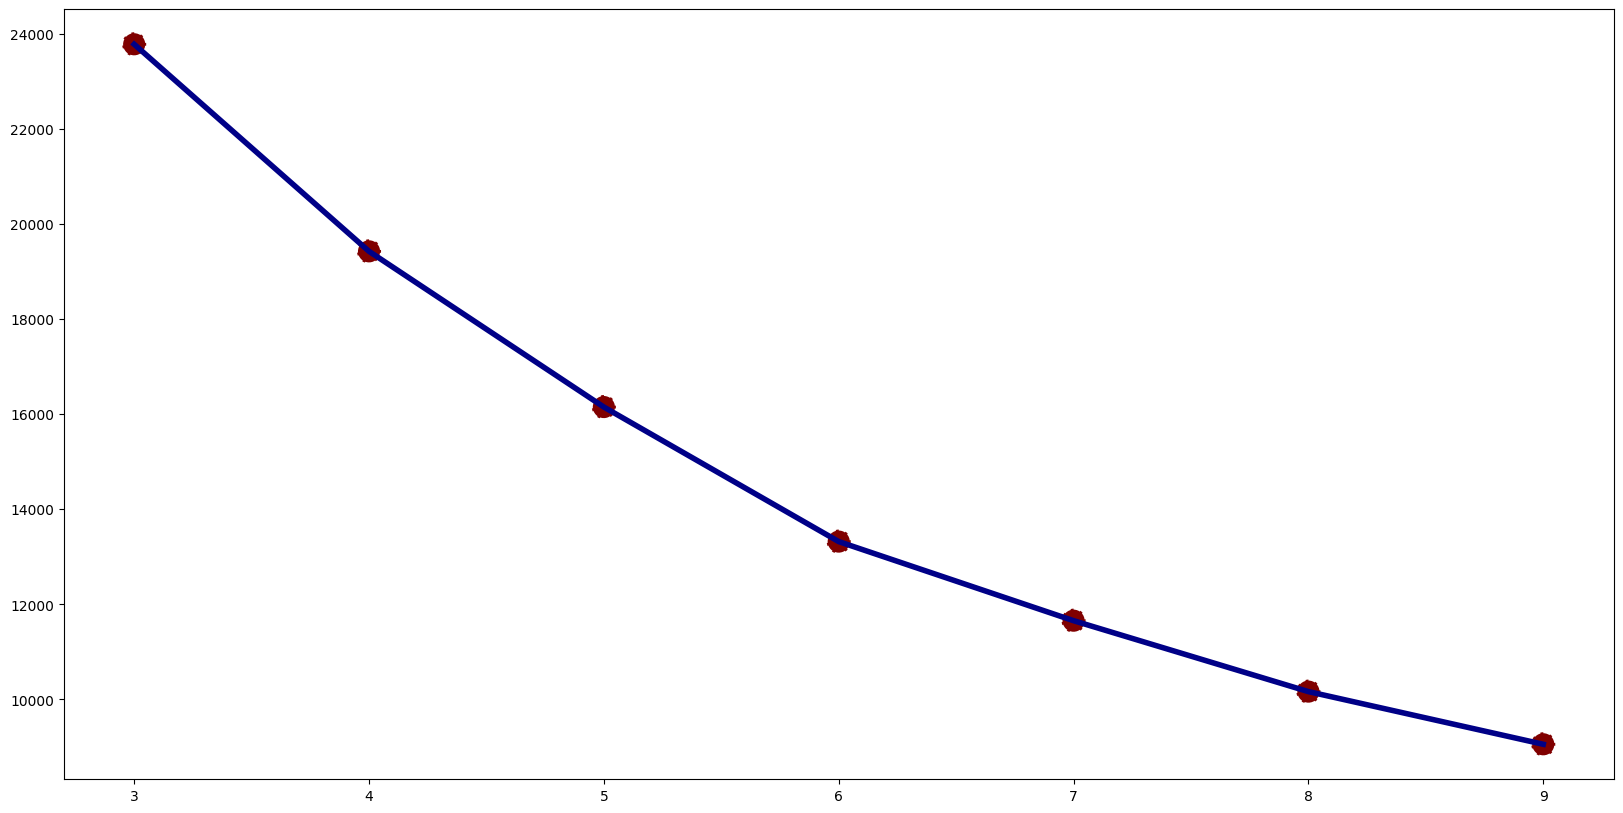

In [ ]:
from sklearn.cluster import KMeans
inertia = []

for i in range(3, 10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_std)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(20, 10))

sns.lineplot(x=range(3, 10), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(3, 10), y=inertia, s=300, color='#800000',  linestyle='--')


In [ ]:
perc = [0.1,0.2,0.3,00.4,0.5,0.6,0.7,0.8,0.9]
dataset.describe(percentiles=perc)

,Frequency_Order,Frequency_Cancel,monetary,total_quantity,total_price,total_country,total_stockcode,total_description,recency
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,4.239707,0.835773,2032.755923,1181.584172,319.121193,1.001830,61.211116,61.563815,94.047118
std,7.685252,2.137575,8952.025481,5035.091772,1281.010819,0.042742,85.425119,86.293362,100.765435
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000
10%,1.000000,0.000000,151.307000,73.000000,20.774000,1.000000,7.000000,7.000000,7.000000
20%,1.000000,0.000000,241.196000,128.000000,41.052000,1.000000,12.000000,12.000000,13.000000
30%,1.000000,0.000000,344.042000,190.000000,63.572000,1.000000,19.000000,19.000000,24.000000
40%,2.000000,0.000000,480.790000,268.400000,93.506000,1.000000,26.000000,26.000000,34.000000
50%,2.000000,0.000000,659.435000,372.000000,128.925000,1.000000,35.000000,35.000000,52.000000
60%,3.000000,0.000000,923.772000,533.600000,179.128000,1.000000,48.000000,48.000000,73.000000


**Tidak ada perbedaan yang significant. Karena itu, Kita memilih menggunakan metode RFM**

## Modeling and Evaluation with All Data



### Scaling

In [ ]:
feat=['recency','Frequency_Order','Frequency_Cancel','monetary']
data_rfm=dataset[feat].copy()
data_rfm.head()

,recency,Frequency_Order,Frequency_Cancel,monetary
0,3,201,47,143711.17
1,4,124,45,40519.84
2,3,93,35,12076.15
3,5,55,31,8507.13
4,3,91,27,60632.75


In [ ]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(data_rfm)

In [ ]:
feats = list(dataset)
new_df = pd.DataFrame(data = X_std, columns = feat)
new_df.head()

,recency,Frequency_Order,Frequency_Cancel,monetary
0,-0.903658,25.605251,21.599015,15.828219
1,-0.893733,15.584914,20.663268,4.299752
2,-0.903658,11.550753,15.984534,1.122041
3,-0.883808,6.605652,14.113040,0.723313
4,-0.903658,11.290485,12.241546,6.546753


### Best K

<Axes: >

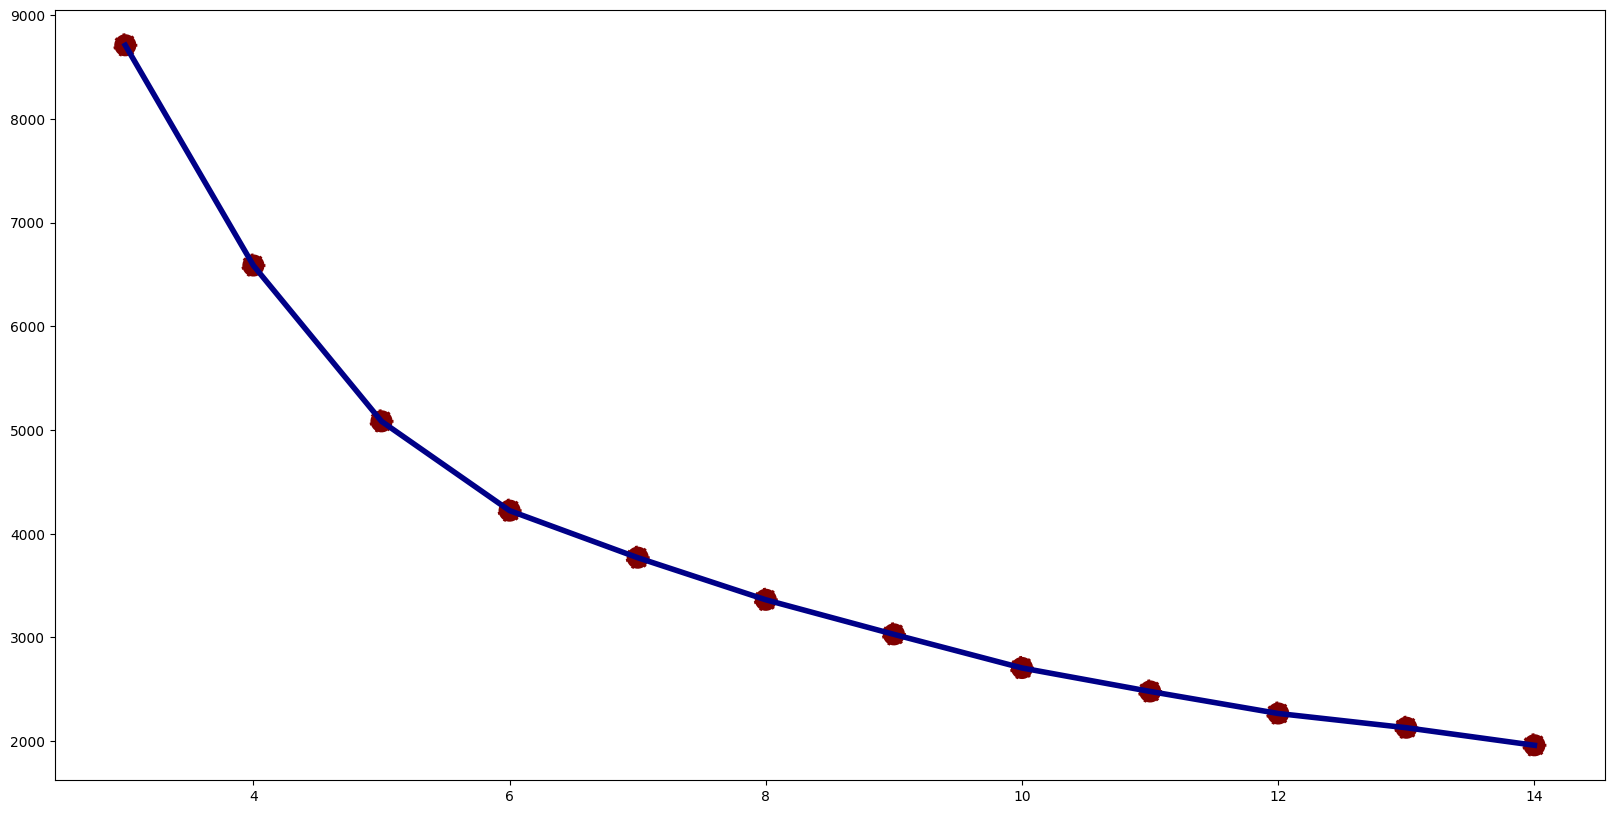

In [ ]:
from sklearn.cluster import KMeans
inertia = []

for i in range(3, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_std)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(20, 10))

sns.lineplot(x=range(3, 15), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(3, 15), y=inertia, s=300, color='#800000',  linestyle='--')


### Clustering

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X_std)

KMeans(n_clusters=5, random_state=0)

In [ ]:
dataset['clusters'] = kmeans.labels_
dataset.head()

,Frequency_Order,Frequency_Cancel,monetary,total_quantity,total_price,total_country,total_stockcode,total_description,recency,clusters,CustomerID
0,201,47,143711.17,80490,31025.29,1,1794,1824,3,1,14911.0
1,124,45,40519.84,22834,19956.37,1,1331,1353,4,1,17841.0
2,93,35,12076.15,6187,7778.46,1,832,839,3,1,14606.0
3,55,31,8507.13,2088,5994.95,1,331,338,5,1,14527.0
4,91,27,60632.75,38147,6245.10,1,571,580,3,1,15311.0


In [ ]:
retail.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [ ]:
retail['Quantity'] = retail['Quantity'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
dataset['CustomerID'] = CustomerID

In [ ]:
def data_cluster():
    q='''
        select
            dt.clusters,
            da.*
        from retail da
        join dataset dt on da.CustomerID=dt.CustomerID

    '''
    return q


data_cluster = ps.sqldf(data_cluster())
data_cluster.head(3)

,clusters,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,2,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00.000000,2.55,17850.0,United Kingdom
1,2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00.000000,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00.000000,2.75,17850.0,United Kingdom


In [ ]:
data_cluster.describe()

,clusters,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000,401604.000000
mean,0.884882,12.863134,3.474064,15281.160818
std,1.242949,179.581848,69.764035,1714.006089
min,0.000000,0.000000,0.000000,12346.000000
25%,0.000000,2.000000,1.250000,13939.000000
50%,0.000000,5.000000,1.950000,15145.000000
75%,2.000000,12.000000,3.750000,16784.000000
max,4.000000,80995.000000,38970.000000,18287.000000


## Cluster Analysis

In [ ]:
dataset.groupby('clusters').agg({
                            'recency' : ['mean'],
                            'Frequency_Order' : ['mean'],
                            'Frequency_Cancel': ['mean'],
                            'monetary' : ['mean','median']

})

recency Frequency_Order Frequency_Cancel       monetary  \
                mean            mean             mean           mean   
clusters                                                               
0          45.463618        3.563084         0.524366    1297.751944   
1           9.000000      104.700000        27.600000   50091.459000   
2          17.685315       17.293706         5.101399    9575.720105   
3           9.666667       43.000000         5.166667  190808.536667   
4         251.172253        1.499069         0.295158     572.367142   

                      
              median  
clusters              
0            785.520  
1          37602.120  
2           5680.440  
3         181431.645  
4            306.635

### Cluster Distribution

In [ ]:
dist_cluster = dataset.groupby('clusters').agg({
    'CustomerID' : ['count']

}).reset_index()
dist_cluster.columns = ['clusters','total customer']
dist_cluster

,clusters,total customer
0,0,2996
1,1,10
2,2,286
3,3,6
4,4,1074


In [ ]:
# kemungkinan / bisa jadi cluster 1 dan 3 adalah outlier

<Axes: xlabel='clusters', ylabel='total customer'>

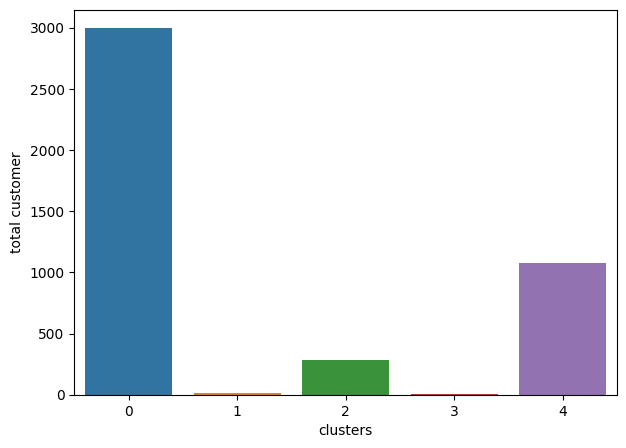

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(x='clusters', y='total customer', data=dist_cluster)

dari graph diatas, mayoritas user berada di cluster 0<br>
<!-- 0 : hibernating<br>
2 : recent customers atau new customers<br>
4 : lost customers<br>
6 : customers with need attention<br> -->

0 : customer need attention <br>
1 : potential loyal customer <br>
2 : reguler customer <br>
3 : loyal customer <br>
4 : potential **lost customer**

**artinya, online retail tersebut sedang TIDAK BAIK BAIK SAJA, karena di dominasi oleh user "tidak produktif"**

### End Customer - country

In [ ]:
def data_country():
    q='''
        select
            clusters,
            Country,
            count(distinct CustomerID) as total_end_cust
        from data_cluster
        group by 1, 2
        order by 1, 3 desc

    '''
    return q


data_country = ps.sqldf(data_country())
data_country.head(3)

,clusters,Country,total_end_cust
0,0,United Kingdom,2715
1,0,Germany,64
2,0,France,60


In [ ]:
data_country.head()

,clusters,Country,total_end_cust
0,0,United Kingdom,2715
1,0,Germany,64
2,0,France,60
3,0,Spain,24
4,0,Switzerland,16


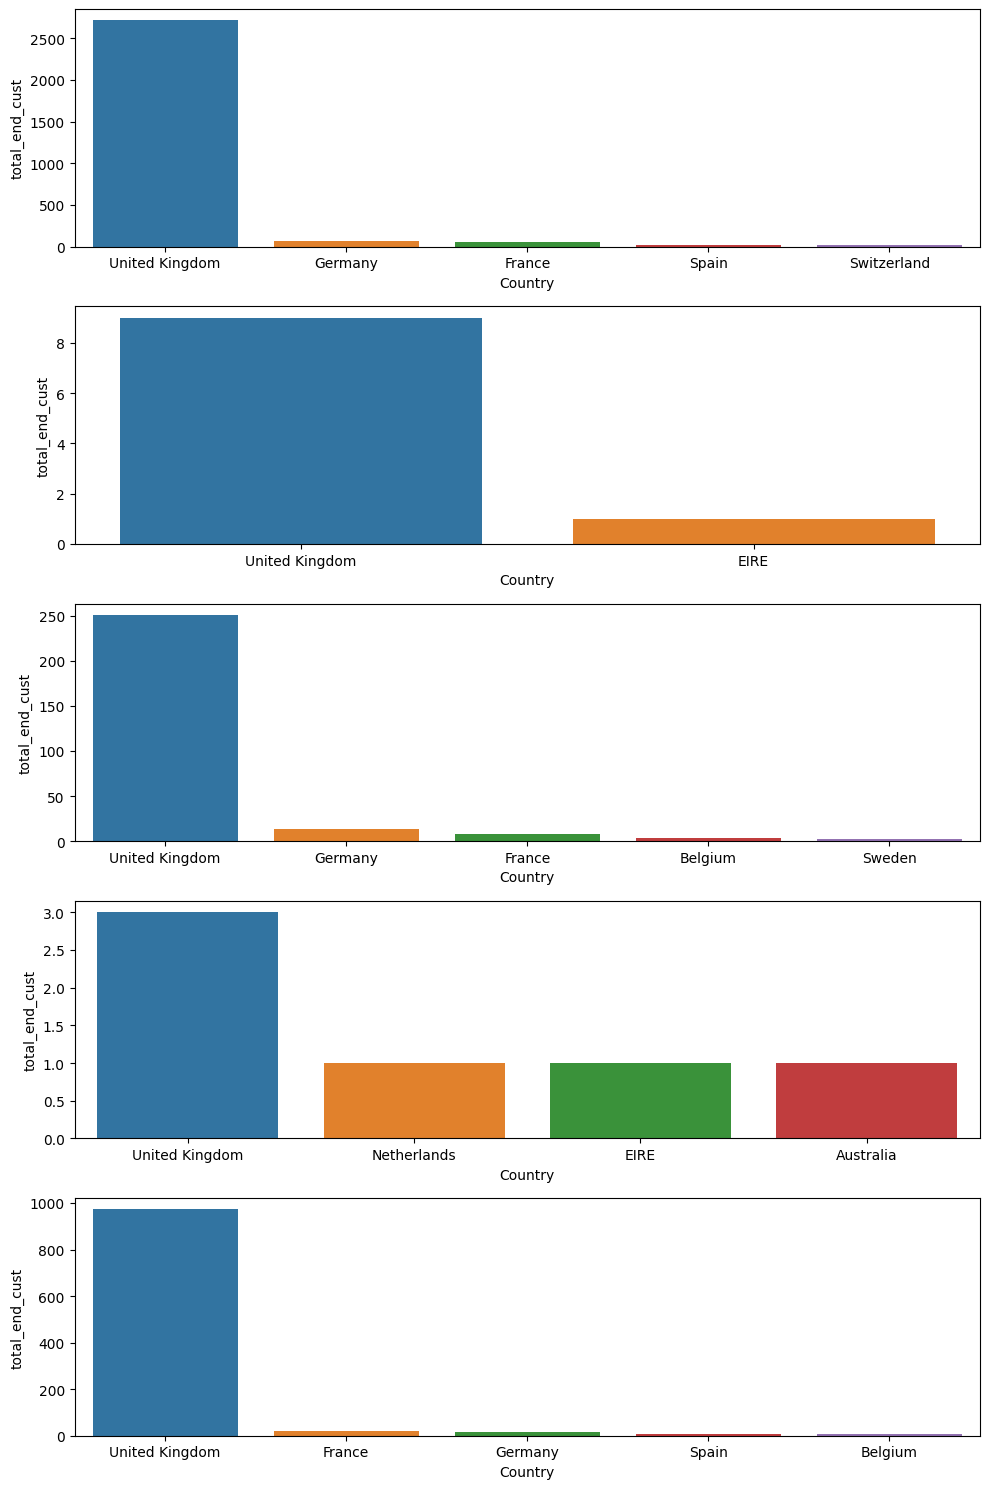

In [ ]:
fig,ax = plt.subplots(5,1,figsize=(10,15))

sns.barplot(x='Country', y='total_end_cust', data=data_country[data_country['clusters']==0][0:5], ax=ax[0])
sns.barplot(x='Country', y='total_end_cust', data=data_country[data_country['clusters']==1][0:5], ax=ax[1])
sns.barplot(x='Country', y='total_end_cust', data=data_country[data_country['clusters']==2][0:5], ax=ax[2])
sns.barplot(x='Country', y='total_end_cust', data=data_country[data_country['clusters']==3][0:5], ax=ax[3])
sns.barplot(x='Country', y='total_end_cust', data=data_country[data_country['clusters']==4][0:5], ax=ax[4])
# sns.barplot(x='Country', y='total_end_cust', data=data_city[data_city['clusters']==6][0:5], ax=ax[5])
plt.tight_layout()

In [ ]:
# Setiap cluster kebanyakan berasal dari UK namun disetiap cluster memiliki perbedaan pola sehingga bisa kita jadikan acuan

### End Customer - Product / Description

In [ ]:
data_cluster.head(3)

,clusters,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,2,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00.000000,2.55,17850.0,United Kingdom
1,2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00.000000,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00.000000,2.75,17850.0,United Kingdom


In [ ]:
def data_product():
    q='''
        select
            clusters,
            Description,
            count(distinct CustomerID) as total_end_cust
        from data_cluster
        group by 1, 2
        order by 1, 3 desc

    '''
    return q


data_p = ps.sqldf(data_product())
data_p.head(3)

,clusters,Description,total_end_cust
0,0,REGENCY CAKESTAND 3 TIER,584
1,0,WHITE HANGING HEART T-LIGHT HOLDER,575
2,0,PAPER CHAIN KIT 50'S CHRISTMAS,493


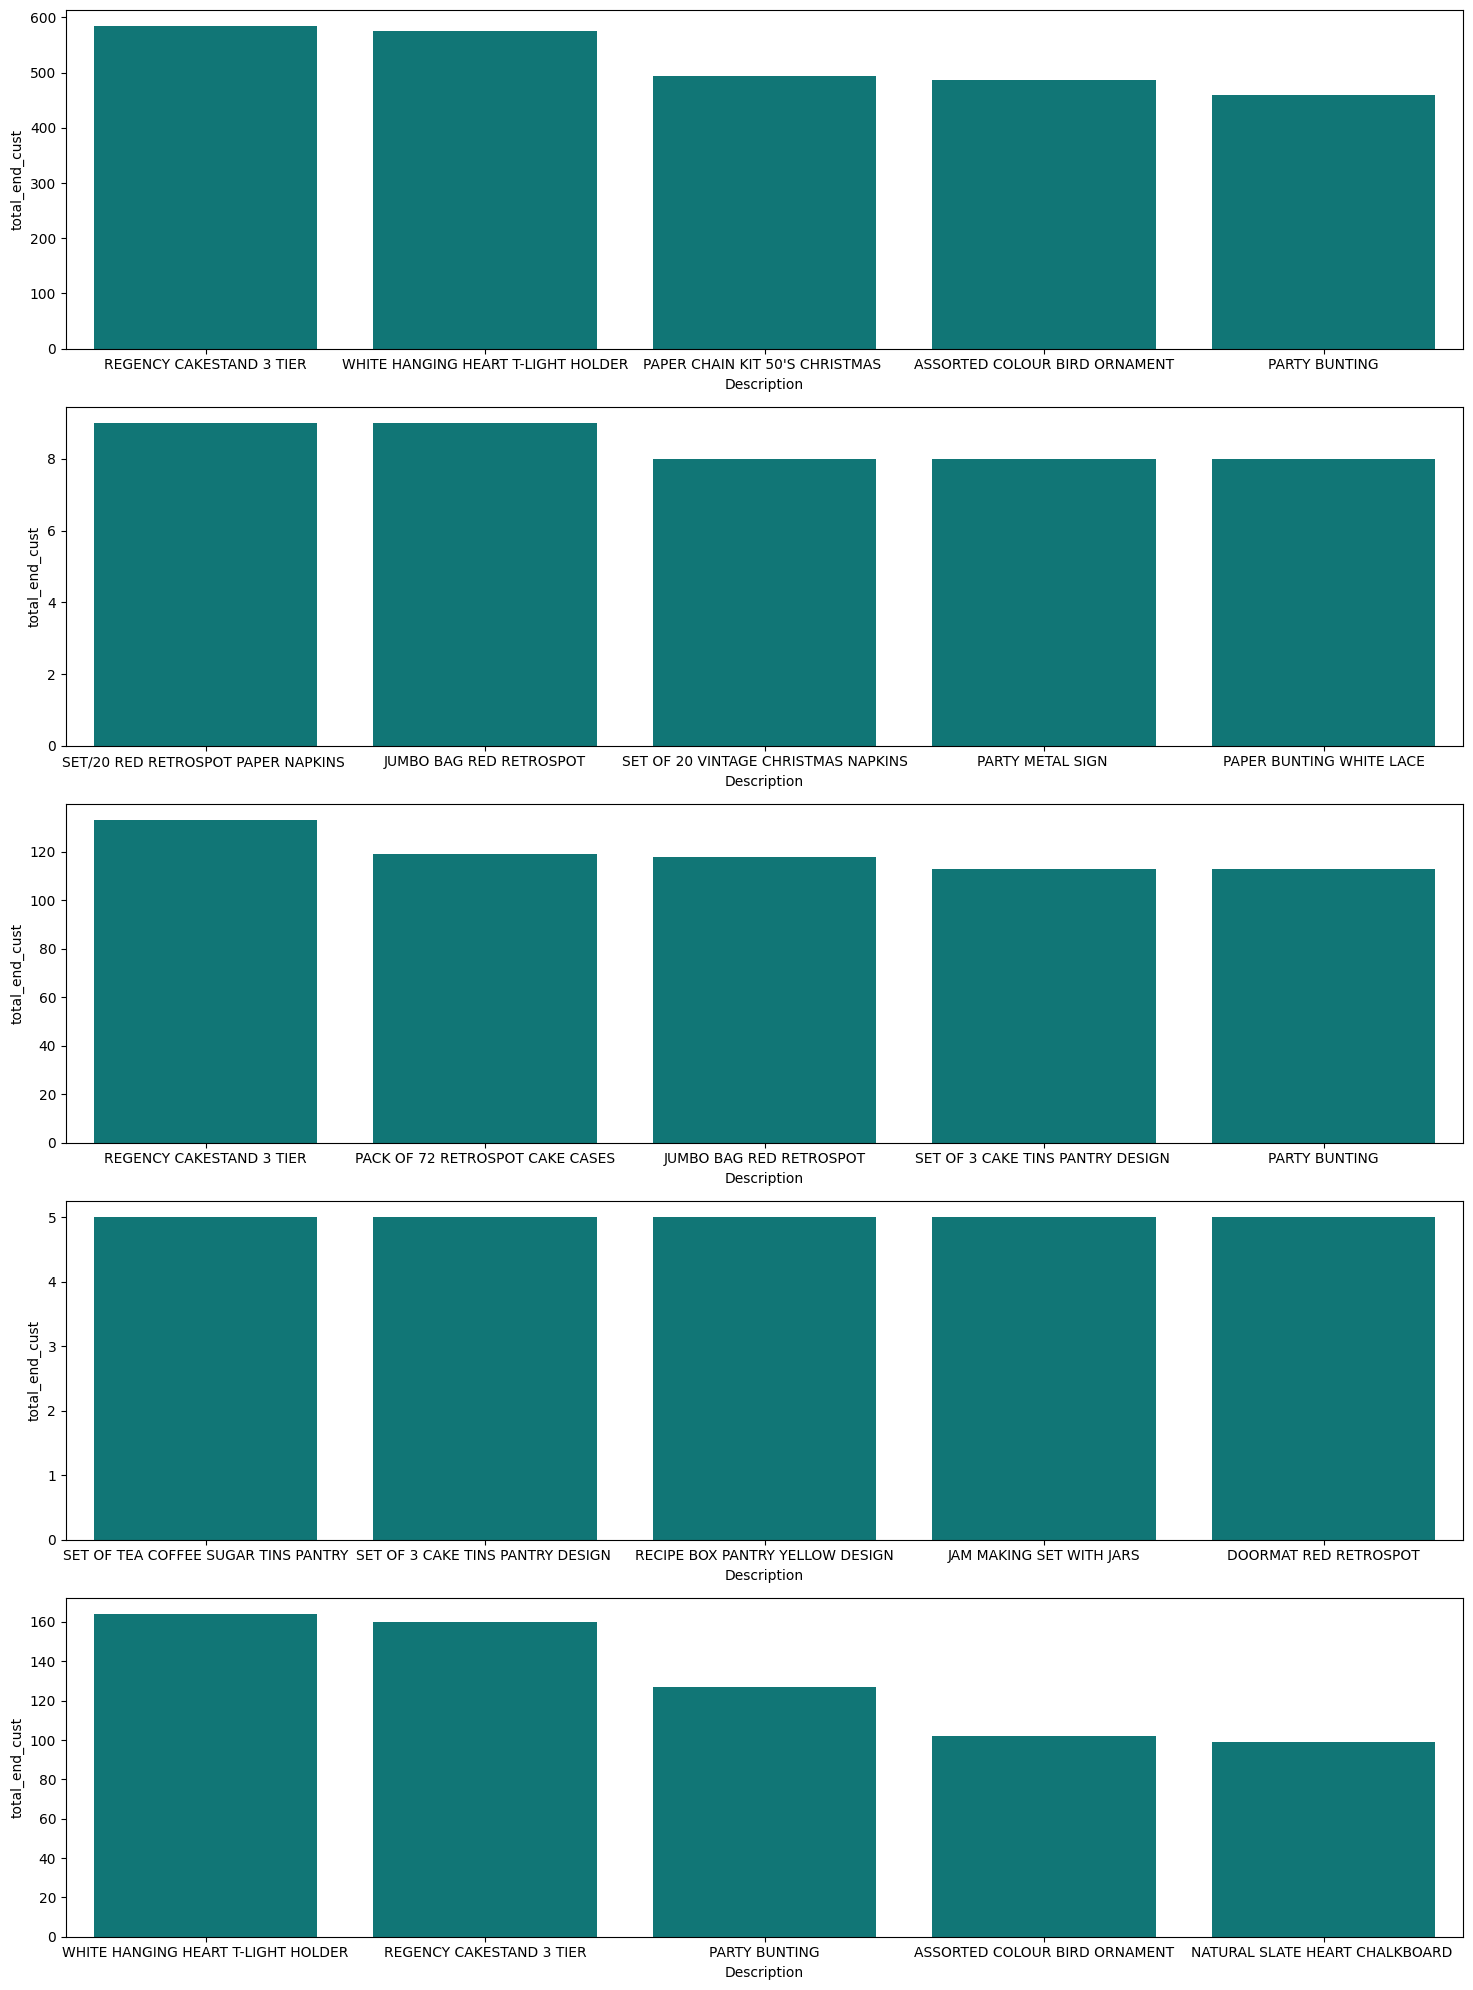

In [ ]:
fig,ax = plt.subplots(5,1,figsize=(15,20))

sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==0][0:5], ax=ax[0], color='#008787')
sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==1][0:5], ax=ax[1], color='#008787')
sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==2][0:5], ax=ax[2], color='#008787')
sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==3][0:5], ax=ax[3], color='#008787')
sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==4][0:5], ax=ax[4], color='#008787')
# sns.barplot(x='Description', y='total_end_cust', data=data_p[data_p['clusters']==6][0:5], ax=ax[5], color='#008787')
plt.tight_layout()

masing-masing cluster menunjukkan perbedaan rekomendasi product